# Importing Python modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import pandas as pd
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u

import matplotlib.pyplot as plt

plt.rcParams['text.usetex']= True
plt.rcParams["font.family"] = "rm"

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# Importing self-written functions

In [2]:
from pathlib import Path
import sys

PROJECT_ROOT = Path().resolve().parent
print(f'root directory: {PROJECT_ROOT}')
sys.path.insert(0, str(PROJECT_ROOT / "packages"))  # moving directory to 'packages' folder to import functions
print(f'current system path: {sys.path[0]}')

from conversions_calculations_and_constants.calculations import SFR_Ha, SFR_UV, log_SFR_mass_Speagle2014, log_SFR_mass_Popesso2023
from conversions_calculations_and_constants.conversions import f_lambda_to_luminosity, M_AB_to_L_nu

root directory: /Users/MarissaPerry/Documents/undergrad/projects/capstone
current system path: /Users/MarissaPerry/Documents/undergrad/projects/capstone/packages


# Loading in data

In [3]:
sample_df = pd.read_pickle('../outputs/checkpoints/sample_computation.pkl')

lum_ratio_mass_correlation = pd.read_csv('../outputs/checkpoints/lum_ratio_mass_correlation.csv')
ratio_frac_values = pd.read_csv('../outputs/checkpoints/ratio_frac_values.csv')
SFMS_Ha_df = pd.read_csv('../outputs/checkpoints/SFMS_Ha_df.csv')
SFMS_UV_df = pd.read_csv('../outputs/checkpoints/SFMS_UV_df.csv')
linear_regression_result = pd.read_csv('../outputs/checkpoints/linear_regression_result.csv')

# literature data
Clarke2024_df = pd.read_pickle('../outputs/checkpoints/Clarke2024_df.pkl')
ratio_frac_values_Clarke2024 = pd.read_csv('../outputs/checkpoints/ratio_frac_values_Clarke2024.csv')

print('max redshift:',max(sample_df['Z SPEC']))
print('min redshift:',min(sample_df['Z SPEC']))

print('max stellar mass:', max(sample_df['MASS MEDIAN']))
print('median stellar mass:', np.median(sample_df['MASS MEDIAN']))
print('min stellar mass:', min(sample_df['MASS MEDIAN']))

print('faintest galaxy (UV absolute magnitude):', min(sample_df['ABSOLUTE MAG 1500 MEDIAN']))

max redshift: 6.990099906921387
min redshift: 0.7770000100135803
max stellar mass: 10.853661780842874
median stellar mass: 8.591230506580342
min stellar mass: 7.039009720076924
faintest galaxy (UV absolute magnitude): -23.616570370089363


In [4]:
len(sample_df)

343

# Sample charateristics

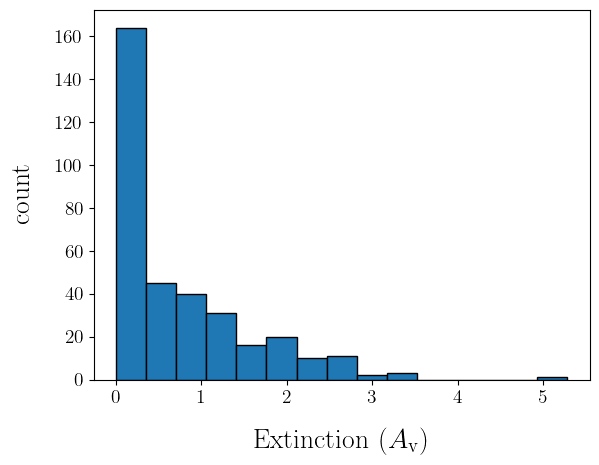

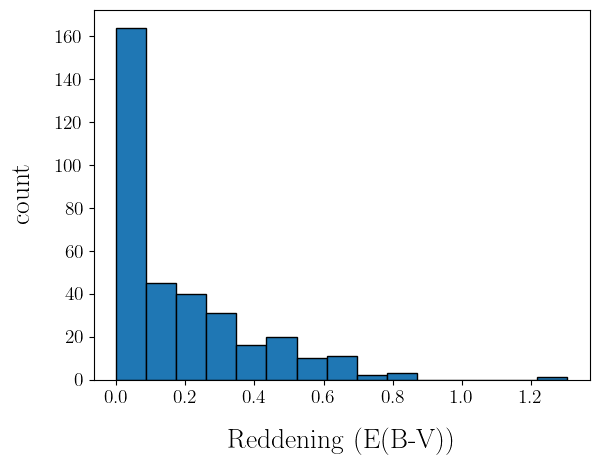

In [5]:
plt.figure()
plt.hist(sample_df["A_V"], bins=15, edgecolor='k', linewidth=1)
plt.xlabel(r'Extinction ($A_{\rm{}v}$)', fontsize=20, labelpad=15)
plt.ylabel('count', fontsize=20, labelpad=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig('../outputs/plots/A_v_distribution.png', dpi=500, bbox_inches='tight')
plt.show()

plt.figure()
plt.hist(sample_df["REDDENING"], bins=15, edgecolor='k', linewidth=1)
plt.xlabel(r'Reddening (E(B-V))', fontsize=20, labelpad=15)
plt.ylabel('count', fontsize=20, labelpad=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.savefig('../outputs/plots/reddening_distribution.png', dpi=500, bbox_inches='tight')
plt.show()

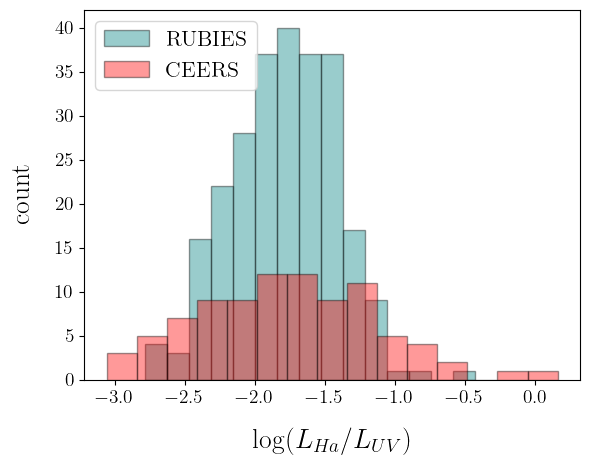

In [6]:
plt.figure()
plt.hist(sample_df[sample_df['SURVEY'] == 'RUBIES']["LOG H-ALPHA-TO-UV LUMINOSITY RATIO"], alpha=0.4, color='teal', bins=15, edgecolor='k', linewidth=1, label='RUBIES')
plt.hist(sample_df[sample_df['SURVEY'] == 'CEERS']["LOG H-ALPHA-TO-UV LUMINOSITY RATIO"], alpha=0.4, color='red', bins=15, edgecolor='k', linewidth=1, label='CEERS')
plt.xlabel(r'log($L_{Ha}$/$L_{UV}$)', fontsize=20, labelpad=15)
plt.ylabel('count', fontsize=20, labelpad=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=16, loc='upper left')
plt.savefig('../outputs/plots/burstiness_parameter_surveys.png', dpi=500, bbox_inches='tight')
plt.show()

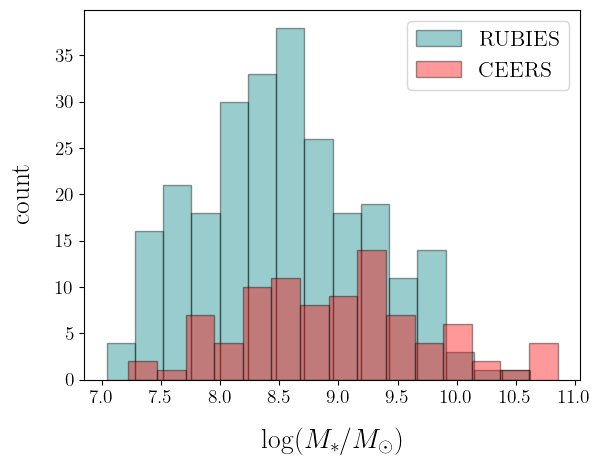

In [7]:
plt.figure()
plt.hist(sample_df[sample_df['SURVEY'] == 'RUBIES']["MASS MEDIAN"], alpha=0.4, color='teal', bins=15, edgecolor='k', linewidth=1, label='RUBIES')
plt.hist(sample_df[sample_df['SURVEY'] == 'CEERS']["MASS MEDIAN"], alpha=0.4, color='red', bins=15, edgecolor='k', linewidth=1, label='CEERS')
plt.xlabel(r'log($M_*$/$M_{\odot}$)', fontsize=20, labelpad=15)
plt.ylabel('count', fontsize=20, labelpad=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=16, loc='upper right')
plt.savefig('../outputs/plots/masses_surveys.png', dpi=500, bbox_inches='tight')
plt.show()

In [8]:
# a dictionary where the keys are the bin values and the values are the corresponding DataFrames
df_split_by_bins = {}

# Iterate over each unique value in 'Z BIN'
bins = sample_df['Z BIN'].unique()
for bin_value in bins:
    # Filter the main DataFrame for each bin_value
    df_split_by_bins[bin_value] = sample_df[sample_df['Z BIN'] == bin_value]

label_list = ['z = 1 - 2.5','z = 2.5 - 4','z = 4 - 5.5','z = 5.5 - 7']
color_list = ['#F56476', '#638492', '#45B69C', '#FF8133']  

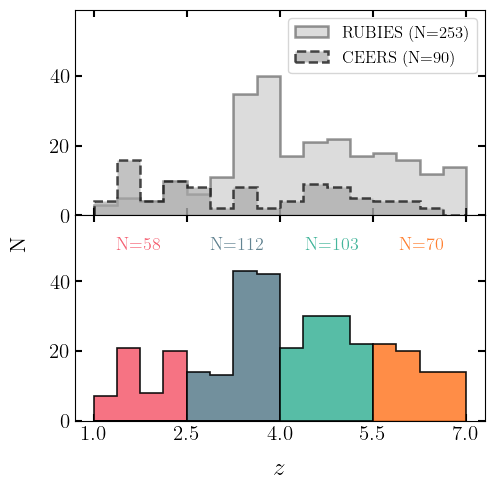

In [9]:
# redshift bin edges
z_edges = [1, 2.5, 4, 5.5, 7]

# number of sub-bins per redshift bin
bins_per_range = 4

# Create sub-binned histogram edges that align with z_edges
common_bins = []
for i in range(len(z_edges) - 1):
    sub_bins = np.linspace(z_edges[i], z_edges[i+1], bins_per_range + 1)
    common_bins.extend(sub_bins[:-1])  # exclude duplicate right-edge
common_bins.append(z_edges[-1])  # add final edge

# plotting figure
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(5, 5), sharex=True)

# --- Top: Survey-based distribution ---
ax1.hist(sample_df[sample_df['SURVEY'] == 'RUBIES']['Z SPEC'],
         bins=common_bins, histtype='step', alpha=0.4, fill=True,
         facecolor='#A9A9A9', edgecolor='k', linewidth=1.8, label=f'RUBIES (N={len(sample_df[sample_df['SURVEY'] == 'RUBIES'])})')

ax1.hist(sample_df[sample_df['SURVEY'] == 'CEERS']['Z SPEC'],
         bins=common_bins, histtype='step', alpha=0.7, fill=True,
         facecolor='#A9A9A9', edgecolor='k', linewidth=1.8, linestyle='dashed', label=f'CEERS (N={len(sample_df[sample_df['SURVEY'] == 'CEERS'])})')

ax1.legend(fontsize=12)
ax1.tick_params(labelsize=12)
ax1.tick_params(axis="both", direction="in", labelsize=15, top=True, right=True, length=5, width=1.5)
ax1.set_ylim(0, 59)

# --- Bottom: Redshift bin distribution ---
x_position = 0.1
for i, bin in enumerate(bins):
    df = df_split_by_bins[bin]
    zspec = df['Z SPEC']
    ax2.hist(zspec, bins=common_bins, histtype='step', fill=True, alpha=0.9, label=label_list[i], 
             color=color_list[i], edgecolor='k', linewidth=1.2)
    
    txt = ax2.text(x_position, 0.83,
             f"N={len(df)}", 
             color=color_list[i], 
             fontsize=13, 
             weight='bold',
             transform=ax2.transAxes)
    # txt.set_path_effects([
    #     path_effects.Stroke(linewidth=0.1, foreground='black'),
    #     path_effects.Normal()
    # ])
    x_position += 0.23

ax2.set_xlabel(r'$z$', fontsize=18, labelpad=10)
# ax2.set_ylabel('Number of Galaxies', fontsize=14, labelpad=5)
fig.supylabel('N', fontsize=16)
ax2.set_xticks([1, 2.5, 4, 5.5, 7])
ax2.tick_params(labelsize=12)
ax2.tick_params(axis="both", direction="in", labelsize=15, top=True, right=True, length=5, width=1.5)
ax2.set_ylim(0, 59)

# Finalize and save
plt.tight_layout()
plt.subplots_adjust(wspace=0, hspace=0)  
plt.savefig('../outputs/plots/sample_redshift_distribution.pdf', dpi=500, bbox_inches='tight')
plt.show()

# Flux Sensitivity

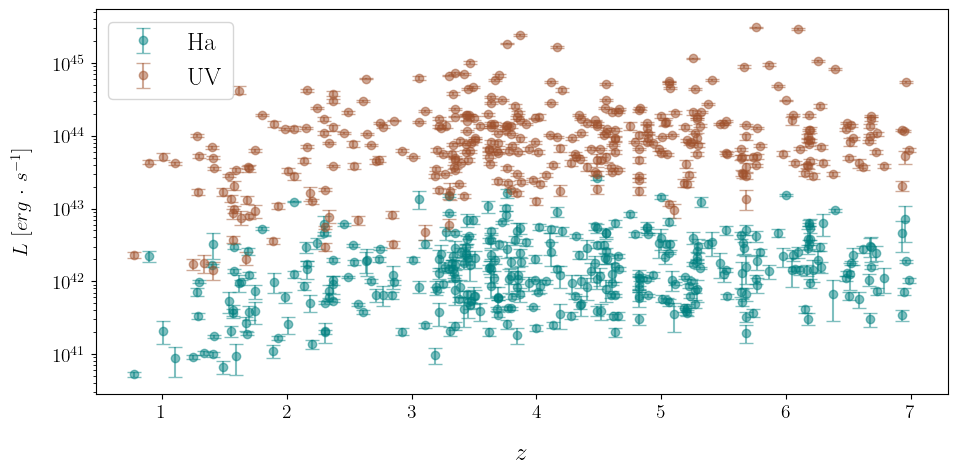

In [10]:
plt.figure(figsize=(11,5))
plt.ylabel(r'$L$ [$erg$ $\cdot$ $s^{-1}$]',fontsize=15, labelpad=15) 
plt.xlabel(r'$z$',fontsize=18, labelpad=15)
plt.errorbar(sample_df['Z SPEC'], sample_df['H-ALPHA INTEGRATED LUMINOSITY'], yerr=sample_df['H-ALPHA INTEGRATED LUMINOSITY MEAN ERROR'], color='teal', alpha=0.5, fmt ='o',markersize=6,capsize=5, label='Ha')
plt.errorbar(sample_df['Z SPEC'], sample_df['UV LUMINOSITY DUST-CORRECTED MEDIAN'], yerr=(sample_df['UV LUMINOSITY DUST-CORRECTED 16% ERROR'],sample_df['UV LUMINOSITY DUST-CORRECTED 84% ERROR']), color='sienna', alpha=0.5, fmt = 'o', markersize=6, capsize=5, label='UV')
plt.yscale('log')
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.legend(fontsize=18, loc='upper left')
plt.savefig('../outputs/plots/redshift_flux.pdf',dpi=500,bbox_inches='tight')
plt.show()

# SFR(H-alpha) and SFR(UV)
* Sample completeness: comparison of H-alpha emission (as given by SFR(Ha)) in context of redshift

In [11]:
def linear_model(x, m, b):
    pivot_point = 8.6  # using a fixed reference mass (the median value within the whole sample)
    return  m * (x - pivot_point) + b

In [12]:
# values from Finkelstein+2025, Table 5 and 6 --------------
G395M_emission_line_5_sigma_depth = 1.1e-18  # [erg/s/cm^2]   also using PRISM, but Medium Grating will be best to represent the lower limit
# NIRCam_median_catalog_5_sigma_depth = 28.5   # [AB mag]       From Table 5, we focus on NIRCam filters relevant for capturing rest-frame 1500 Å at different redshifts: (F200W, F277W, F356W)

# converting to luminosities -------------------------------
SFR_Ha_limit = []
SFR_UV_limit = []
for i, bin in enumerate(bins):

    # dataframe of current bin
    df = df_split_by_bins[bin]

    # computing redshift percentiles ------------
    z_bin_median = df['Z SPEC'].quantile(q=0.50)
    # -------------------------------------------

    # SFR(Ha) limit ----------
    # converting f_lambda --> L
    L_Ha_limit = f_lambda_to_luminosity(G395M_emission_line_5_sigma_depth, z_bin_median)
    # converting L --> SFR
    SFR_Ha_vals = SFR_Ha(L_Ha_limit)
    SFR_Ha_limit.append(SFR_Ha_vals)
    # ------------------------
    
    # SFR(UV) limit ----------
    # saving the faintest reliably detected rest-frame UV source value
    M_lim = df['ABSOLUTE MAG 1500 16% ERROR'].max()
    # converting M_AB --> L_v
    L_UV_nu_limit = M_AB_to_L_nu(M_lim)
    # converting L_v --> SFR
    SFR_UV_vals = SFR_UV(L_UV_nu_limit)
    SFR_UV_limit.append(SFR_UV_vals)
    # ------------------------

    print(f"{bin}:")
    print(f"  Faintest SFR(UV): {df['UV SFR'].min():.2f}")
    print(f"  Limiting SFR(UV): {SFR_UV_vals:.2f}")

1-2.5:
  Faintest SFR(UV): 0.06
  Limiting SFR(UV): 0.07
2.5-4:
  Faintest SFR(UV): 0.13
  Limiting SFR(UV): 0.12
4-5.5:
  Faintest SFR(UV): 0.38
  Limiting SFR(UV): 0.20
5.5-7:
  Faintest SFR(UV): 0.55
  Limiting SFR(UV): 0.64


In [13]:
SFR_Ha_limit

[0.10855021212528326,
 0.5669911340359384,
 1.2076754991620955,
 2.2300688137094635]

In [14]:
SFR_UV_limit

[0.07498447566332184,
 0.11736171046009314,
 0.19854605527871216,
 0.6432668436714485]

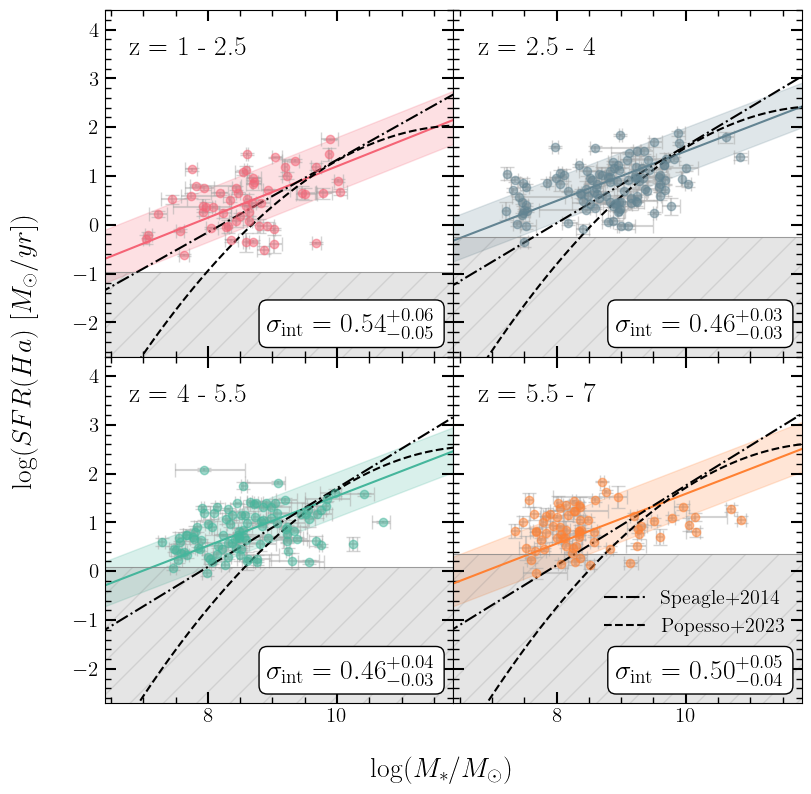

In [15]:
# Create 2x2 grid for 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(9, 9), sharex=True, sharey=True)
fig.supxlabel(r'log($M_*$/$M_{\odot}$)', fontsize=20, y=0.02)
fig.supylabel(r'log($SFR(Ha)$ [$M_{\odot}/yr$])', fontsize=20, x=0.02)

for i, bin in enumerate(bins):
    ax = axs[i//2, i%2]

    # data from of current z-bin
    df = df_split_by_bins[bin]

    xbot = df['MASS 16% ERROR']
    xtop = df['MASS 84% ERROR']
    x_data = df['MASS MEDIAN']
    y_data = np.log10(df['H-ALPHA SFR'])
    y_data_err = df['H-ALPHA SFR ERROR'] / (df['H-ALPHA SFR'] * np.log(10))  # propogate error

    # extracting MCMC results from current z-bin
    SFMS_row = SFMS_Ha_df.loc[SFMS_Ha_df['Z BIN'] == bin]
    m = SFMS_row['SLOPE'].values[0]
    b = SFMS_row['INTERCEPT'].values[0]
    intrinsic_scatter = SFMS_row['INTRINSIC SCATTER'].values[0]
    y_scatter_lower = SFMS_row['SCATTER LOWER ERROR'].values[0]
    y_scatter_upper = SFMS_row['SCATTER UPPER ERROR'].values[0]
    y_scatter_16 = intrinsic_scatter - y_scatter_lower
    y_scatter_84 = intrinsic_scatter + y_scatter_upper

    # SFMS fit line
    x_arr = np.linspace(6, 12, 100)
    y_model = linear_model(x_arr, m, b)

    # intrinsic scatter region
    y_scatter_upper = y_model + y_scatter_84
    y_scatter_lower = y_model - y_scatter_16

    # data
    ax.errorbar(x_data, y_data, xerr=(xbot, xtop), yerr=y_data_err, color=color_list[i], ecolor='#A9A9A9', alpha=0.5, 
                fmt='o', markersize=6, capsize=5)
    
    # MCMC fit
    ax.plot(x_arr, y_model, color=color_list[i], linestyle='-')
    
    # intrinsic scatter region
    ax.fill_between(x_arr, y_scatter_lower, y_scatter_upper, color=color_list[i], alpha=0.2)

    # limiting SFR
    # ax.axhline(y=np.log10(SFR_Ha_limit_16th_err[i]), color='grey', linestyle=':', linewidth=1.2)
    ax.axhline(y=np.log10(SFR_Ha_limit[i]), color='grey', linestyle='solid', linewidth=0.5)
    # ax.axhline(y=np.log10(SFR_Ha_limit_84th_err[i]), color='grey', linestyle=':', linewidth=1.2)
    ax.fill_between(x_arr, -5, np.log10(SFR_Ha_limit[i]), color='grey',  hatch='/', alpha=0.2)

    # literature value
    x_arr = np.linspace(6, 12, 100).reshape((-1, 1))
    z_median = np.median(df['Z SPEC'])
    ax.plot(x_arr, log_SFR_mass_Speagle2014(x_arr, z_median), color='black', linestyle='-.', label='Speagle+2014')
    ax.plot(x_arr, log_SFR_mass_Popesso2023(x_arr, z_median), color='black', linestyle='--', label='Popesso+2023')
    
    textstr = (rf"$\sigma_{{\rm int}} = {intrinsic_scatter:.2f}^{{+{y_scatter_84 - intrinsic_scatter:.2f}}}_{{-{intrinsic_scatter - y_scatter_16:.2f}}}$")
    ax.text(0.95, 0.05, textstr, transform=ax.transAxes, fontsize=20,
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    ax.text(
        0.07, 0.87,  
        label_list[i], 
        color='black', 
        fontsize=20, 
        fontweight='heavy',
        transform=ax.transAxes  
    )

    if i == 3:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, fontsize=14.5, loc=(0.41,0.17), frameon=False)
    
    ax.set_ylim(-2.7,4.4)
    ax.set_xlim(6.4,11.8)
    
    # adding major & minor ticks on all sides
    ax.tick_params(axis="both", direction="in", labelsize=15, top=True, right=True, length=8, width=1.5)
    
    # adding minor ticks
    ax.minorticks_on()
    ax.tick_params(axis="both", which="minor", direction="in", length=4, width=1.0, top=True, right=True)

plt.subplots_adjust(wspace=0, hspace=0)  
plt.savefig("../outputs/plots/SFR_Ha.pdf", dpi=500, bbox_inches="tight")
plt.show()

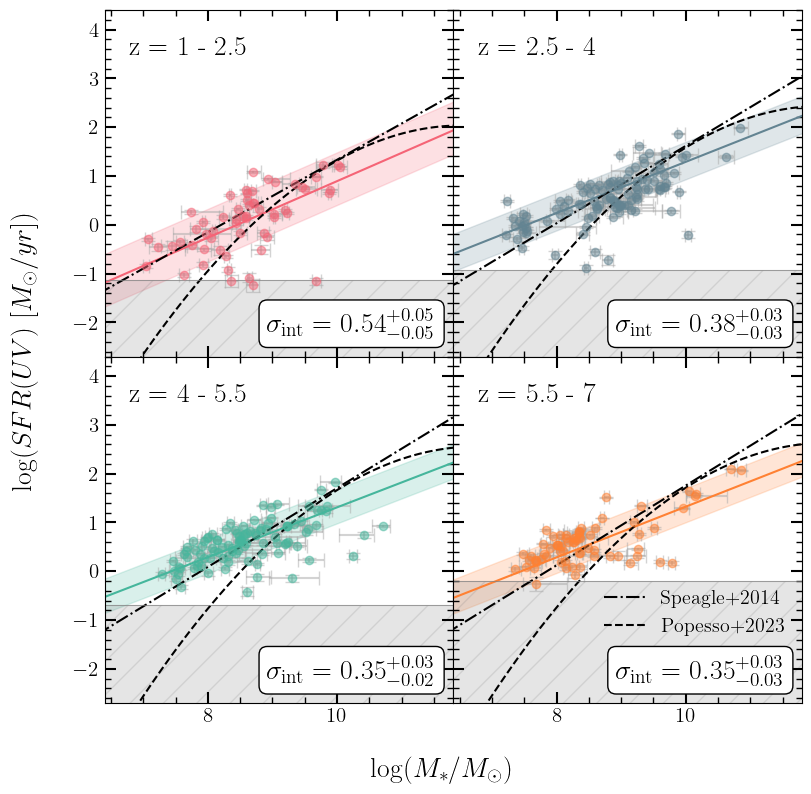

In [16]:
# Create 2x2 grid for 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(9, 9), sharex=True, sharey=True)
fig.supxlabel(r'log($M_*$/$M_{\odot}$)', fontsize=20, y=0.02)
fig.supylabel(r'log($SFR(UV)$ [$M_{\odot}/yr$])', fontsize=20, x=0.02)

for i, bin in enumerate(bins):
    ax = axs[i//2, i%2]

    # data from of current z-bin
    df = df_split_by_bins[bin]

    xbot = df['MASS 16% ERROR']
    xtop = df['MASS 84% ERROR']
    x_data = df['MASS MEDIAN']
    y_data = np.log10(df['UV SFR'])
    y_data_err = df['UV SFR ERROR'] / (df['UV SFR'] * np.log(10))  # propogate error

    # extracting MCMC results from current z-bin
    SFMS_row = SFMS_UV_df.loc[SFMS_UV_df['Z BIN'] == bin]
    m = SFMS_row['SLOPE'].values[0]
    b = SFMS_row['INTERCEPT'].values[0]
    intrinsic_scatter = SFMS_row['INTRINSIC SCATTER'].values[0]
    y_scatter_lower = SFMS_row['SCATTER LOWER ERROR'].values[0]
    y_scatter_upper = SFMS_row['SCATTER UPPER ERROR'].values[0]
    y_scatter_16 = intrinsic_scatter - y_scatter_lower
    y_scatter_84 = intrinsic_scatter + y_scatter_upper

    # SFMS fit line
    x_arr = np.linspace(6, 12, 100)
    y_model = linear_model(x_arr, m, b)

    # intrinsic scatter region
    y_scatter_upper = y_model + y_scatter_84
    y_scatter_lower = y_model - y_scatter_16

    # data
    ax.errorbar(x_data, y_data, xerr=(xbot, xtop), yerr=y_data_err, color=color_list[i], ecolor='#A9A9A9', alpha=0.5, 
                fmt='o', markersize=6, capsize=5)
    
    # MCMC fit
    ax.plot(x_arr, y_model, color=color_list[i], linestyle='-')
    
    # intrinsic scatter region
    ax.fill_between(x_arr, y_scatter_lower, y_scatter_upper, color=color_list[i], alpha=0.2)

    # literature value
    z_median = np.median(df['Z SPEC'])
    ax.plot(x_arr, log_SFR_mass_Speagle2014(x_arr, z_median), color='black', linestyle='-.', label='Speagle+2014')
    ax.plot(x_arr, log_SFR_mass_Popesso2023(x_arr, z_median), color='black', linestyle='--', label='Popesso+2023')

    # limiting SFR
    # ax.axhline(y=np.log10(SFR_UV_limit_16th_err[i]), color='grey', linestyle=':', linewidth=1.2)
    ax.axhline(y=np.log10(SFR_UV_limit[i]), color='grey', linestyle='solid', linewidth=0.5)
    # ax.axhline(y=np.log10(SFR_UV_limit_84th_err[i]), color='grey', linestyle=':', linewidth=1.2)
    ax.fill_between(x_arr, -5, np.log10(SFR_UV_limit[i]), color='grey',  hatch='/', alpha=0.2)
    
    textstr = (rf"$\sigma_{{\rm int}} = {intrinsic_scatter:.2f}^{{+{y_scatter_84 - intrinsic_scatter:.2f}}}_{{-{intrinsic_scatter - y_scatter_16:.2f}}}$")
    ax.text(0.95, 0.05, textstr, transform=ax.transAxes, fontsize=20,
            verticalalignment='bottom', horizontalalignment='right',
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
    
    ax.text(
        0.07, 0.87,  
        label_list[i], 
        color='black', 
        fontsize=20, 
        fontweight='heavy',
        transform=ax.transAxes  
    )

    if i == 3:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, fontsize=14.5, loc=(0.41,0.17), frameon=False)
    
    ax.set_ylim(-2.7,4.4)
    ax.set_xlim(6.4,11.8)

    # adding major & minor ticks on all sides
    ax.tick_params(axis="both", direction="in", labelsize=15, top=True, right=True, length=8, width=1.5)
    
    # adding minor ticks
    ax.minorticks_on()
    ax.tick_params(axis="both", which="minor", direction="in", length=4, width=1.0, top=True, right=True)

plt.subplots_adjust(wspace=0, hspace=0)  
plt.savefig('../outputs/plots/SFR_UV.pdf',dpi=500,bbox_inches='tight')
plt.show()

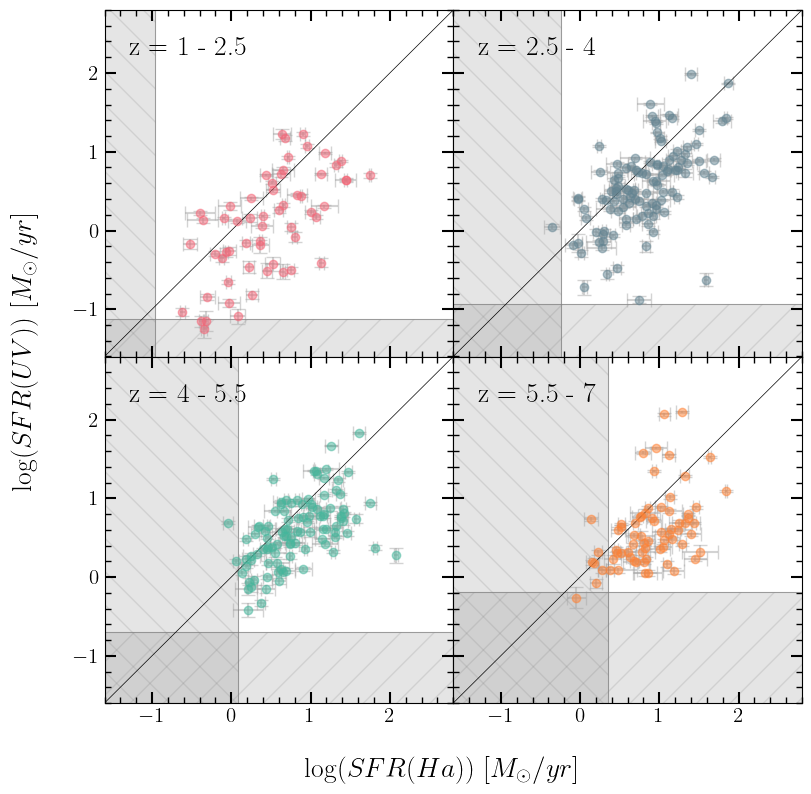

In [17]:
# Create 2x2 grid for 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(9, 9), sharex=True, sharey=True)
fig.supxlabel(r'log($SFR(Ha)$) [$M_{\odot}/yr$]', fontsize=20, y=0.02)
fig.supylabel(r'log($SFR(UV)$) [$M_{\odot}/yr$]', fontsize=20, x=0.02)

for i, bin in enumerate(bins):
    ax = axs[i//2, i%2]

    # data from of current z-bin
    df = df_split_by_bins[bin]

    x_data = np.log10(df['H-ALPHA SFR'])
    x_data_err = df['H-ALPHA SFR ERROR'] / (df['H-ALPHA SFR'] * np.log(10))  # propogate error
    y_data = np.log10(df['UV SFR'])
    y_data_err = df['UV SFR ERROR'] / (df['UV SFR'] * np.log(10))  # propogate error

    # data
    ax.errorbar(x_data, y_data, xerr=x_data_err, yerr=y_data_err, color=color_list[i], ecolor='#A9A9A9', alpha=0.5, 
                fmt='o', markersize=6, capsize=5)

    arr = np.linspace(-1.6, 2.8, 100)
    
    # limiting SFR(Ha)
    ax.axvline(x=np.log10(SFR_Ha_limit[i]), color='grey', linestyle='solid', linewidth=0.5)
    ax.fill_betweenx(arr, -5, np.log10(SFR_Ha_limit[i]), color='grey',  hatch='\\', alpha=0.2)

    # limiting SFR(UV)
    ax.axhline(y=np.log10(SFR_UV_limit[i]), color='grey', linestyle='solid', linewidth=0.5)
    ax.fill_between(arr, -5, np.log10(SFR_UV_limit[i]), color='grey',  hatch='/', alpha=0.2)
    ax.plot(arr,arr,color='black', linewidth=0.5)
    
    ax.text(
        0.07, 0.87,  
        label_list[i], 
        color='black', 
        fontsize=20, 
        fontweight='heavy',
        transform=ax.transAxes  
    )

    if i == 3:
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, fontsize=14.5, loc=(0.41,0.17), frameon=False)
    
    ax.set_ylim(-1.6,2.8)
    ax.set_xlim(-1.6,2.8)

    # adding major & minor ticks on all sides
    ax.tick_params(axis="both", direction="in", labelsize=15, top=True, right=True, length=8, width=1.5)
    
    # adding minor ticks
    ax.minorticks_on()
    ax.tick_params(axis="both", which="minor", direction="in", length=4, width=1.0, top=True, right=True)

plt.subplots_adjust(wspace=0, hspace=0)  
plt.savefig('../outputs/plots/SFR_tracer_comparison.png',dpi=500,bbox_inches='tight')
plt.show()

In [18]:
# computing the inverse-variance-weighted average values for the Ha and UV intrinsic scatter:

# Ha ------------------------------------------------------------------------------------------------------------
sigma_int_Ha = SFMS_Ha_df['INTRINSIC SCATTER'].values
y_scatter_lower = SFMS_Ha_df['SCATTER LOWER ERROR'].values
y_scatter_upper = SFMS_Ha_df['SCATTER UPPER ERROR'].values
y_scatter_16 = sigma_int_Ha - y_scatter_lower
y_scatter_84 = sigma_int_Ha + y_scatter_upper
sigma_int_Ha_err = (y_scatter_84 - y_scatter_16) / 2  # Approximate uncertainty

# weights (inverse variance)
weights_Ha = 1 / sigma_int_Ha_err**2

# weighted average
weighted_avg_sigma_int_Ha = np.sum(sigma_int_Ha * weights_Ha) / np.sum(weights_Ha)

# weighted standard deviation
weighted_std_sigma_int_Ha = np.sqrt(1 / np.sum(weights_Ha))

print(f"<sigma_Ha>: {weighted_avg_sigma_int_Ha:.3f} ± {weighted_std_sigma_int_Ha:.3f}")

# UV --------------------------------------------------------------------------------------------------------------
sigma_int_UV = SFMS_UV_df['INTRINSIC SCATTER'].values
y_scatter_lower = SFMS_UV_df['SCATTER LOWER ERROR'].values
y_scatter_upper = SFMS_UV_df['SCATTER UPPER ERROR'].values
y_scatter_16 = sigma_int_UV - y_scatter_lower
y_scatter_84 = sigma_int_UV + y_scatter_upper
sigma_int_UV_err = (y_scatter_84 - y_scatter_16) / 2  # Approximate uncertainty

# weights (inverse variance)
weights_UV = 1 / sigma_int_UV_err**2

# weighted average
weighted_avg_sigma_int_UV = np.sum(sigma_int_UV * weights_UV) / np.sum(weights_UV)

# weighted standard deviation
weighted_std_sigma_int_UV = np.sqrt(1 / np.sum(weights_UV))

print(f"<sigma_UV>: {weighted_avg_sigma_int_UV:.3f} ± {weighted_std_sigma_int_UV:.3f}")

# difference between Ha and UV -------------------------------------------------------------------------------------

scatter_diff = weighted_avg_sigma_int_Ha - weighted_avg_sigma_int_UV

# propagated uncertainty
scatter_diff_err = np.sqrt(1 / np.sum(weights_Ha) + 1 / np.sum(weights_UV))

print(f"<sigma_Ha> - <sigma_UV>: {scatter_diff:.3f} ± {scatter_diff_err:.3f}")

<sigma_Ha>: 0.476 ± 0.019
<sigma_UV>: 0.376 ± 0.015
<sigma_Ha> - <sigma_UV>: 0.101 ± 0.024


In [19]:
above_low_mass = 54
above_low_mass_err = 4
above_high_mass = 24
above_high_mass_err = 3

diff = above_low_mass - above_high_mass

# propagated uncertainty
diff_err = np.sqrt(1 / np.sum(above_low_mass_err) + 1 / np.sum(above_high_mass_err))

print(f"<f_above,lower-mass> - <f_above, higher-mass>: {diff:.3f} ± {diff_err:.3f}")

<f_above,lower-mass> - <f_above, higher-mass>: 30.000 ± 0.764


# Fraction of sample outside of equilibrium range of Ha-to-UV

In [20]:
z_left_err = []
z_right_err = []

# ----------------------------------------------
z_bins = ['1-2.5', '2.5-4', '4-5.5', '5.5-7']
mass_bins = ['7-8.5', '8.5-10.9']
redshifts = [0, 2.5, 4, 5.5, 7.1]
masses = [6.5, 8.5, 11]
# ----------------------------------------------

sample_df['Z BIN'] = pd.cut(sample_df['Z SPEC'], bins=redshifts, labels=z_bins, right=False)
sample_df['MASS BIN'] = pd.cut(sample_df['MASS MEDIAN'], bins=masses, labels=mass_bins, right=False)

for i, z_bin in enumerate(z_bins):
    # current Z BIN
    df_z_bin = sample_df[sample_df['Z BIN'] == z_bin]
    
    for j, m_bin in enumerate(mass_bins):
        # current MASS BIN
        mass_bin_df = df_z_bin[df_z_bin['MASS BIN'] == m_bin]
        median_z = np.median(mass_bin_df['Z SPEC'])

        # get the bin edges from the label (e.g., '1-2.5' → zmin=1.0, zmax=2.5)
        zmin, zmax = map(float, z_bin.split('-'))
        z_left_err.append(median_z - zmin)
        z_right_err.append(zmax - median_z)

ratio_frac_values['LEFT ERR Z'] = z_left_err 
ratio_frac_values['RIGHT ERR Z'] = z_right_err
ratio_frac_values

,Z BIN,MEDIAN Z,Z ERROR LOW,Z ERROR HIGH,MASS BIN,TOTAL SOURCES,FRAC ABOVE,FRAC ABOVE LOWER ERROR,FRAC ABOVE UPPER ERROR,FRAC BELOW,FRAC BELOW LOWER ERROR,FRAC BELOW UPPER ERROR,FRAC EQUILIBRIUM,FRAC EQUILIBRIUM LOWER ERROR,FRAC EQUILIBRIUM UPPER ERROR,LEFT ERR Z,RIGHT ERR Z
0,1-2.5,1.699000,0.699000,0.801000,7-8.5,24,0.750000,0.083333,0.083333,0.125000,0.041667,0.083333,0.083333,0.041667,0.125000,0.699000,0.801000
1,1-2.5,1.851200,0.851200,0.648800,8.5-10.9,34,0.470588,0.088235,0.088235,0.441176,0.088235,0.088235,0.088235,0.058824,0.058824,0.851200,0.648800
2,2.5-4,3.423400,0.923400,0.576600,7-8.5,33,0.696970,0.090909,0.090909,0.151515,0.060606,0.090909,0.121212,0.060606,0.090909,0.923400,0.576600
3,2.5-4,3.471000,0.971000,0.529000,8.5-10.9,79,0.379747,0.050633,0.063291,0.468354,0.063291,0.063291,0.139241,0.037975,0.050633,0.971000,0.529000
4,4-5.5,4.628411,0.628411,0.871589,7-8.5,49,0.510204,0.081633,0.061224,0.346939,0.081633,0.081633,0.142857,0.061224,0.081633,0.628411,0.871589
5,4-5.5,4.827050,0.827050,0.672950,8.5-10.9,54,0.370370,0.074074,0.074074,0.481481,0.074074,0.074074,0.148148,0.055556,0.055556,0.827050,0.672950
6,5.5-7,6.187200,0.687200,0.812800,7-8.5,47,0.617021,0.085106,0.085106,0.234043,0.063830,0.085106,0.127660,0.042553,0.085106,0.687200,0.812800
7,5.5-7,6.110000,0.610000,0.890000,8.5-10.9,23,0.347826,0.130435,0.086957,0.521739,0.130435,0.130435,0.130435,0.086957,0.130435,0.610000,0.890000


In [21]:
z_left_err = []
z_right_err = []

# ----------------------------------------------
z_bins = ['1.4-2.7', '2.7-4', '4-5', '5-6', '6-7']
redshifts = [1, 2.7, 4, 5, 6, 7]
# ----------------------------------------------

for i, z_bin in enumerate(z_bins):
    
    z_midpoint = ratio_frac_values_Clarke2024.loc[ratio_frac_values_Clarke2024['Z BIN'] == z_bin, 'Z BIN MIDPOINT'].values[0]

    # get the bin edges from the label (e.g., '1-2.5' → zmin=1.0, zmax=2.5)
    zmin, zmax = map(float, z_bin.split('-'))
    z_left_err.append(z_midpoint - zmin)
    z_right_err.append(zmax - z_midpoint)

ratio_frac_values_Clarke2024['LEFT ERR Z'] = z_left_err
ratio_frac_values_Clarke2024['RIGHT ERR Z'] = z_right_err
ratio_frac_values_Clarke2024

,Z BIN,Z BIN MIDPOINT,FRAC ABOVE,FRAC BELOW,FRAC EQUILIBRIUM,LEFT ERR Z,RIGHT ERR Z
0,1.4-2.7,2.05,0.13,0.33,0.54,0.65,0.65
1,2.7-4,3.35,0.13,0.16,0.71,0.65,0.65
2,4-5,4.50,0.32,0.16,0.52,0.50,0.50
3,5-6,5.50,0.17,0.35,0.48,0.50,0.50
4,6-7,6.50,0.21,0.14,0.64,0.50,0.50


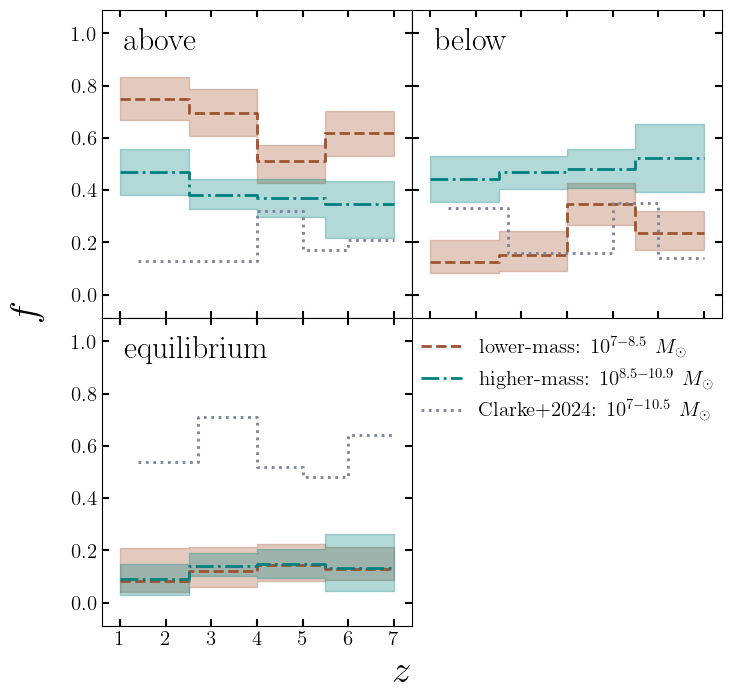

In [22]:
def plot_fraction_panel(ax, frac_col, err_lower_col, err_upper_col, panel_label, ratio_frac_values, mass_colors, line_styles):
    for i, mass_bin in enumerate(ratio_frac_values['MASS BIN'].unique()):

        # data for each mass bin
        df_mass = ratio_frac_values[ratio_frac_values['MASS BIN'] == mass_bin]
        z_med = df_mass['MEDIAN Z'].values
        z_left = df_mass['Z ERROR LOW'].values
        z_right = df_mass['Z ERROR HIGH'].values
        z_min = z_med - z_left
        z_max = z_med + z_right

        f = df_mass[frac_col].values
        err_lower = df_mass[err_lower_col].values
        err_upper = df_mass[err_upper_col].values

        # Step-style arrays
        z_step = np.empty(2 * len(z_min))
        f_step = np.empty_like(z_step)
        f_lower = np.empty_like(z_step)
        f_upper = np.empty_like(z_step)

        z_step[0::2] = z_min
        z_step[1::2] = z_max
        f_step[0::2] = f
        f_step[1::2] = f
        f_lower[0::2] = f - err_lower
        f_lower[1::2] = f - err_lower
        f_upper[0::2] = f + err_upper
        f_upper[1::2] = f + err_upper

        mass_str = r'lower-mass: $10^{7-8.5}~M_{\odot}$' if i == 0 else r'higher-mass: $10^{8.5-10.9}~M_{\odot}$'
        ax.plot(z_step, f_step, drawstyle='steps-mid', color=mass_colors[i], linewidth=2,
                linestyle=line_styles[mass_bin], label=mass_str)
        ax.fill_between(z_step, f_lower, f_upper, step='mid', color=mass_colors[i], alpha=0.3)

    # Clarke+2024 data
    z_med = ratio_frac_values_Clarke2024['Z BIN MIDPOINT'].values
    z_left = ratio_frac_values_Clarke2024['LEFT ERR Z'].values
    z_right = ratio_frac_values_Clarke2024['RIGHT ERR Z'].values
    z_min = z_med - z_left
    z_max = z_med + z_right
    
    f = ratio_frac_values_Clarke2024[frac_col].values
    
    z_step = np.empty(2 * len(z_min))
    f_step = np.empty_like(z_step)
    
    z_step[0::2] = z_min
    z_step[1::2] = z_max
    f_step[0::2] = f
    f_step[1::2] = f
    
    ax.plot(z_step, f_step, drawstyle='steps-mid', color='#7C809B', linestyle=':', linewidth=2,
            label='Clarke+2024: $10^{7-10.5}~M_{\odot}$')

    ax.set_ylim(-0.09, 1.09)
    ax.text(0.07, 0.87, panel_label, color='black', fontsize=23, fontweight='heavy', transform=ax.transAxes)


fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
fig.supxlabel(r'$z$', fontsize=28, y=0.03)
fig.supylabel(r'$f$', fontsize=28, x=0.01)

mass_colors = ['sienna', 'teal']
line_styles = {'7-8.5': '--', '8.5-10.9': '-.'}

plot_fraction_panel(axs[0, 0], 'FRAC ABOVE', 'FRAC ABOVE LOWER ERROR', 'FRAC ABOVE UPPER ERROR', 'above', ratio_frac_values, mass_colors, line_styles)
plot_fraction_panel(axs[1, 0], 'FRAC EQUILIBRIUM', 'FRAC EQUILIBRIUM LOWER ERROR', 'FRAC EQUILIBRIUM UPPER ERROR', 'equilibrium', ratio_frac_values, mass_colors, line_styles)
plot_fraction_panel(axs[0, 1], 'FRAC BELOW', 'FRAC BELOW LOWER ERROR', 'FRAC BELOW UPPER ERROR', 'below', ratio_frac_values, mass_colors, line_styles)

axs[1, 1].axis('off')
handles, labels = axs[0, 0].get_legend_handles_labels()
axs[1, 1].legend(handles, labels, fontsize=15, loc='upper center', frameon=False)

for ax in [axs[0, 0], axs[1, 0], axs[0, 1]]:
    ax.set_xlim(0.6, 7.4)
    ax.set_xticks(np.arange(1, 8, 1))
    ax.tick_params(axis="both", direction="in", labelsize=15, top=True, right=True, length=5, width=1.5)

plt.subplots_adjust(wspace=0, hspace=0)  
plt.savefig('../outputs/plots/Ha_UV_fraction_poster.png', dpi=500, bbox_inches='tight')
plt.show()

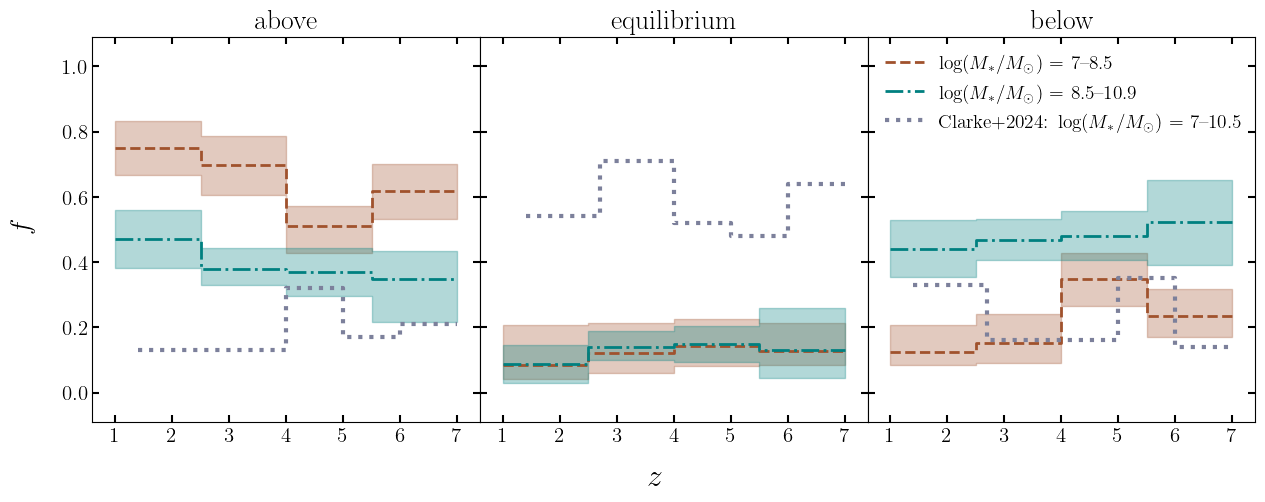

In [23]:
def plot_fraction_panel(ax, frac_col, err_lower_col, err_upper_col, panel_label, ratio_frac_values, mass_colors, line_styles):
    for i, mass_bin in enumerate(ratio_frac_values['MASS BIN'].unique()):

        df_mass = ratio_frac_values[ratio_frac_values['MASS BIN'] == mass_bin]
        z_med = df_mass['MEDIAN Z'].values
        z_left = df_mass['Z ERROR LOW'].values
        z_right = df_mass['Z ERROR HIGH'].values
        z_min = z_med - z_left
        z_max = z_med + z_right

        f = df_mass[frac_col].values
        err_lower = df_mass[err_lower_col].values
        err_upper = df_mass[err_upper_col].values

        # Step-style arrays
        z_step = np.empty(2 * len(z_min))
        f_step = np.empty_like(z_step)
        f_lower = np.empty_like(z_step)
        f_upper = np.empty_like(z_step)

        z_step[0::2] = z_min
        z_step[1::2] = z_max
        f_step[0::2] = f
        f_step[1::2] = f
        f_lower[0::2] = f - err_lower
        f_lower[1::2] = f - err_lower
        f_upper[0::2] = f + err_upper
        f_upper[1::2] = f + err_upper

        mass_str = r'log($M_*$/$M_{\odot}$) = 7–8.5' if i == 0 else r'log($M_*$/$M_{\odot}$) = 8.5–10.9'
        ax.plot(z_step, f_step, drawstyle='steps-mid', color=mass_colors[i], linewidth=2,
                linestyle=line_styles[mass_bin], label=mass_str)
        ax.fill_between(z_step, f_lower, f_upper, step='mid', color=mass_colors[i], alpha=0.3)

    # Clarke+2024 reference
    z_med = ratio_frac_values_Clarke2024['Z BIN MIDPOINT'].values
    z_left = ratio_frac_values_Clarke2024['LEFT ERR Z'].values
    z_right = ratio_frac_values_Clarke2024['RIGHT ERR Z'].values
    z_min = z_med - z_left
    z_max = z_med + z_right

    f = ratio_frac_values_Clarke2024[frac_col].values

    z_step = np.empty(2 * len(z_min))
    f_step = np.empty_like(z_step)
    z_step[0::2] = z_min
    z_step[1::2] = z_max
    f_step[0::2] = f
    f_step[1::2] = f

    ax.plot(z_step, f_step, drawstyle='steps-mid', color='#7C809B', linestyle=':', linewidth=3,
            label='Clarke+2024: log($M_*$/$M_{\odot}$) = 7–10.5')

    ax.set_ylim(-0.09, 1.09)
    ax.set_title(panel_label, fontsize=20)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
fig.supxlabel(r'$z$', fontsize=23, y=-0.03)
fig.supylabel(r'$f$', fontsize=20, x=0.07)

mass_colors = ['sienna', 'teal']
line_styles = {'7-8.5': '--', '8.5-10.9': '-.'}

plot_fraction_panel(axs[0], 'FRAC ABOVE', 'FRAC ABOVE LOWER ERROR', 'FRAC ABOVE UPPER ERROR', 'above', ratio_frac_values, mass_colors, line_styles)
plot_fraction_panel(axs[1], 'FRAC EQUILIBRIUM', 'FRAC EQUILIBRIUM LOWER ERROR', 'FRAC EQUILIBRIUM UPPER ERROR', 'equilibrium', ratio_frac_values, mass_colors, line_styles)
plot_fraction_panel(axs[2], 'FRAC BELOW', 'FRAC BELOW LOWER ERROR', 'FRAC BELOW UPPER ERROR', 'below', ratio_frac_values, mass_colors, line_styles)

handles, labels = axs[0].get_legend_handles_labels()
axs[2].legend(handles, labels, fontsize=14, loc='upper left', frameon=False)

for ax in axs:
    ax.set_xlim(0.6, 7.4)
    ax.set_xticks(np.arange(1, 8, 1))
    ax.tick_params(axis="both", direction="in", labelsize=15, top=True, right=True, length=5, width=1.5)

plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('../outputs/plots/Ha_UV_fraction.pdf', dpi=500, bbox_inches='tight')
plt.show()

# Ha-to-UV Luminosity Ratio

In [24]:
# a dictionary where the keys are the bin values and the values are the corresponding DataFrames
df_split_by_bins = {}

# Iterate over each unique value in 'Z BIN'
for bin_value in bins:
    # Filter the main DataFrame for each bin_value
    df_split_by_bins[bin_value] = sample_df[sample_df['Z BIN'] == bin_value]

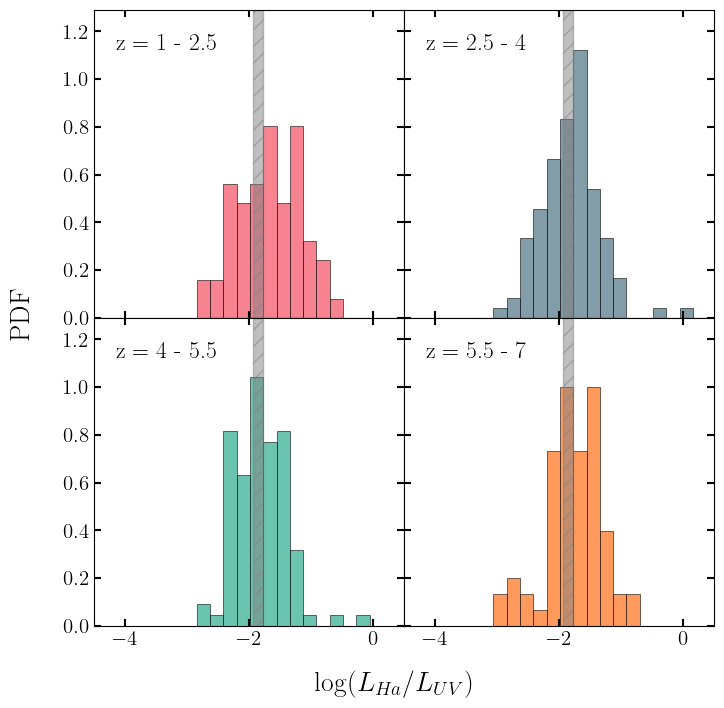

In [25]:
# Get global min and max across all z-bins
all_ratios = pd.concat([df_split_by_bins[bin]['LOG H-ALPHA-TO-UV LUMINOSITY RATIO'] for bin in bins])
vmin, vmax = all_ratios.min(), all_ratios.max()

# Define common bin edges using linspace (ensures equal width)
n_bins = 15
common_bins = np.linspace(vmin, vmax, n_bins + 1)

# Create 2x2 grid for 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
fig.supxlabel(r'log($L_{Ha}$/$L_{UV}$)', fontsize=20, y=0.02)
fig.supylabel('PDF', fontsize=20, x=0.02)

for i, bin in enumerate(bins):
    ax = axs[i//2, i%2]

    # data from of current z-bin
    df = df_split_by_bins[bin]

    log_lum_ratio = df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO']
    log_lum_ratio_err = df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO ERROR']

   # # compute histogram (raw counts, no normalization)
   #  counts, bin_edges = np.histogram(log_lum_ratio, bins=8)
   #  bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
   #  bin_widths = np.diff(bin_edges)

   #  # compute errors BEFORE normalizing
   #  raw_errors = np.sqrt(counts)

    # plot histogram and get normalized counts from Matplotlib
    counts, bin_edges, patches = ax.hist(
        log_lum_ratio, 
        color=color_list[i], 
        alpha=0.8, 
        bins=common_bins,
        edgecolor='black', 
        linewidth=0.5,
        density=True  # normalizes histogram
    )

    # # normalize errors using same transformation as histogram
    # norm_errors = raw_errors / (len(log_lum_ratio) * bin_widths)

    # # poisson errors
    # ax.errorbar(bin_centers, counts, yerr=norm_errors, fmt=',', color=color_list[i], alpha=0.6, capsize=3)

    # for each redshift bin, plot a theoretical threshold
    ax.fill_between(
        [-1.93, -1.78],   # x-range of the shaded region
        -0.5, 2,           # y-limits for the shaded region
        color='gray',  
        hatch='//',
        alpha=0.5 
    )
    
    # legend text
    ax.text(
        0.07, 0.87,  
        label_list[i], 
        color='black', 
        fontsize=17, 
        fontweight='heavy',
        transform=ax.transAxes  
    )

    ax.tick_params(labelsize=14)
    ax.tick_params(labelsize=14)
    
    ax.set_ylim(0, 1.29)
    ax.set_xlim(-4.5,0.5)
    # ax.invert_xaxis()
    ax.tick_params(axis="both", direction="in", labelsize=15, top=True, right=True, length=5, width=1.5)

plt.subplots_adjust(wspace=0, hspace=0)  
plt.savefig('../outputs/plots/lum_ratio_distribution.png',dpi=500,bbox_inches='tight')
plt.show()

In [26]:
median_ratios = []
median_masses = []
top_err = []
bot_err = []
mass_left_err = []
mass_right_err = []
list_masses = []
scatter_std = []

# ----------------------------------------------
mass_bins = ['7-8.5', '8.5-10.9']
masses = [6.5, 8.5, 11]
# ----------------------------------------------

sample_df['MASS BIN'] = pd.cut(sample_df['MASS MEDIAN'], masses, labels=mass_bins, right=False)

for j, m_bin in enumerate(mass_bins):
    # current MASS BIN
    mass_bin_df = sample_df[sample_df['MASS BIN'] == m_bin]

    median_ratio = np.median(mass_bin_df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO'])
    median_mass = np.median(mass_bin_df['MASS MEDIAN'])

    # get the bin edges from the label (e.g., '7-8.5' → zmin=7.0, zmax=8.5)
    mass_min, mass_max = map(float, m_bin.split('-'))
    mass_left_err.append(median_mass - mass_min)
    mass_right_err.append(mass_max - median_mass)

    p16, p84 = np.percentile(mass_bin_df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO'], [16, 84])
    bot_err.append(median_ratio - p16)
    top_err.append(p84 - median_ratio)

    scatter = np.std(mass_bin_df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO'], ddof=1)  # sample std dev
    scatter_std.append(scatter)

    median_ratios.append(median_ratio)
    median_masses.append(median_mass)
    list_masses.append(m_bin)

# saving stats from correlation computation
mass_stats2 = pd.DataFrame()
mass_stats2['MASS BIN'] = list_masses
mass_stats2['MEDIAN RATIO'] = median_ratios
mass_stats2['BOTTOM ERR RATIO'] = bot_err
mass_stats2['TOP ERR RATIO'] = top_err
mass_stats2['MEDIAN MASS'] = median_masses
mass_stats2['LEFT ERR MASS'] = mass_left_err 
mass_stats2['RIGHT ERR MASS'] = mass_right_err
mass_stats2['STD SCATTER'] = scatter_std
mass_stats2

,MASS BIN,MEDIAN RATIO,BOTTOM ERR RATIO,TOP ERR RATIO,MEDIAN MASS,LEFT ERR MASS,RIGHT ERR MASS,STD SCATTER
0,7-8.5,-1.659754,0.374800,0.373911,8.018171,1.018171,0.481829,0.417986
1,8.5-10.9,-1.910312,0.435789,0.472072,9.084757,0.584757,1.815243,0.452819


In [27]:
def bootstrap_std(data, n_bootstrap=1000):
    """
    Bootstrap the standard deviation of the input array.
    
    Parameters:
        data (array-like): Input data.
        n_bootstrap (int): Number of bootstrap iterations.
    
    Returns:
        mean_std (float): Mean of bootstrap standard deviations.
        err_std (float): Standard error of bootstrap standard deviations.
    """
    std_vals = []
    for _ in range(n_bootstrap):
        resampled = np.random.choice(data, size=len(data), replace=True)
        std_vals.append(np.std(resampled, ddof=1))  # sample standard deviation
    return np.mean(std_vals), np.std(std_vals)  # mean and uncertainty

# --------------------------------------------------
# Run for each mass bin
bootstrap_results = []
mass_bins = ['7-8.5', '8.5-10.9']

for m_bin in mass_bins:
    bin_df = sample_df[sample_df['MASS BIN'] == m_bin]
    data = bin_df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO'].dropna().values

    mean_std, err_std = bootstrap_std(data, n_bootstrap=1000)
    bootstrap_results.append((mean_std, err_std))

# Add results to your existing mass_stats2 DataFrame
mass_stats2['BOOTSTRAP STD'] = [x[0] for x in bootstrap_results]
mass_stats2['BOOTSTRAP STD ERR'] = [x[1] for x in bootstrap_results]
mass_stats2

,MASS BIN,MEDIAN RATIO,BOTTOM ERR RATIO,TOP ERR RATIO,MEDIAN MASS,LEFT ERR MASS,RIGHT ERR MASS,STD SCATTER,BOOTSTRAP STD,BOOTSTRAP STD ERR
0,7-8.5,-1.659754,0.374800,0.373911,8.018171,1.018171,0.481829,0.417986,0.414401,0.035473
1,8.5-10.9,-1.910312,0.435789,0.472072,9.084757,0.584757,1.815243,0.452819,0.452035,0.022309


In [28]:
diff = bootstrap_results[0][0] - bootstrap_results[1][0]
diff_err = np.sqrt(bootstrap_results[0][1]**2 + bootstrap_results[1][1]**2)

print(f"Difference in scatter: {diff:.3f} ± {diff_err:.3f} dex")

Difference in scatter: -0.038 ± 0.042 dex


In [29]:
median_ratios = []
median_zs = []
top_err = []
bot_err = []
z_left_err = []
z_right_err = []
list_z_bins = []
list_masses = []

# ----------------------------------------------
z_bins = ['1-2.5', '2.5-4', '4-5.5', '5.5-7']
mass_bins = ['7-8.5', '8.5-10.9']
redshifts = [0, 2.5, 4, 5.5, 7.1]
masses = [6.5, 8.5, 11]
# ----------------------------------------------

sample_df['Z BIN'] = pd.cut(sample_df['Z SPEC'], redshifts, labels=z_bins, right=False)
sample_df['MASS BIN'] = pd.cut(sample_df['MASS MEDIAN'], masses, labels=mass_bins, right=False)

for i, z_bin in enumerate(z_bins):
    # current Z BIN
    df_z_bin = sample_df[sample_df['Z BIN'] == z_bin]
    
    for j, m_bin in enumerate(mass_bins):
        # current MASS BIN
        mass_bin_df = df_z_bin[df_z_bin['MASS BIN'] == m_bin]

        median_ratio = np.median(mass_bin_df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO'])
        median_z = np.median(mass_bin_df['Z SPEC'])

        # errors from percentiles
        # p16, p84 = np.percentile(mass_bin_df['Z SPEC'], [16, 84])
        # z_left_err.append(median_z - p16)
        # z_right_err.append(p84 - median_z)

        # get the bin edges from the label (e.g., '1-2.5' → zmin=1.0, zmax=2.5)
        zmin, zmax = map(float, z_bin.split('-'))
        z_left_err.append(median_z - zmin)
        z_right_err.append(zmax - median_z)

        p16, p84 = np.percentile(mass_bin_df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO'], [16, 84])
        bot_err.append(median_ratio - p16)
        top_err.append(p84 - median_ratio)

        median_ratios.append(median_ratio)
        median_zs.append(median_z)
        list_z_bins.append(z_bin)
        list_masses.append(m_bin)

# saving stats from correlation computation
mass_stats = pd.DataFrame()
mass_stats['Z BIN'] = list_z_bins
mass_stats['MASS BIN'] = list_masses
mass_stats['MEDIAN RATIO'] = median_ratios
mass_stats['BOTTOM ERR RATIO'] = bot_err
mass_stats['TOP ERR RATIO'] = top_err
mass_stats['MEDIAN Z'] = median_zs
mass_stats['LEFT ERR Z'] = z_left_err 
mass_stats['RIGHT ERR Z'] = z_right_err
mass_stats

,Z BIN,MASS BIN,MEDIAN RATIO,BOTTOM ERR RATIO,TOP ERR RATIO,MEDIAN Z,LEFT ERR Z,RIGHT ERR Z
0,1-2.5,7-8.5,-1.507254,0.369688,0.446010,1.699000,0.699000,0.801000
1,1-2.5,8.5-10.9,-1.827697,0.556372,0.625938,1.851200,0.851200,0.648800
2,2.5-4,7-8.5,-1.615459,0.302504,0.359894,3.423400,0.923400,0.576600
3,2.5-4,8.5-10.9,-1.910413,0.403365,0.363672,3.471000,0.971000,0.529000
4,4-5.5,7-8.5,-1.771555,0.299887,0.376089,4.628411,0.628411,0.871589
5,4-5.5,8.5-10.9,-1.913842,0.397896,0.455081,4.827050,0.827050,0.672950
6,5.5-7,7-8.5,-1.606731,0.441428,0.230536,6.187200,0.687200,0.812800
7,5.5-7,8.5-10.9,-1.936115,0.754448,0.428132,6.110000,0.610000,0.890000


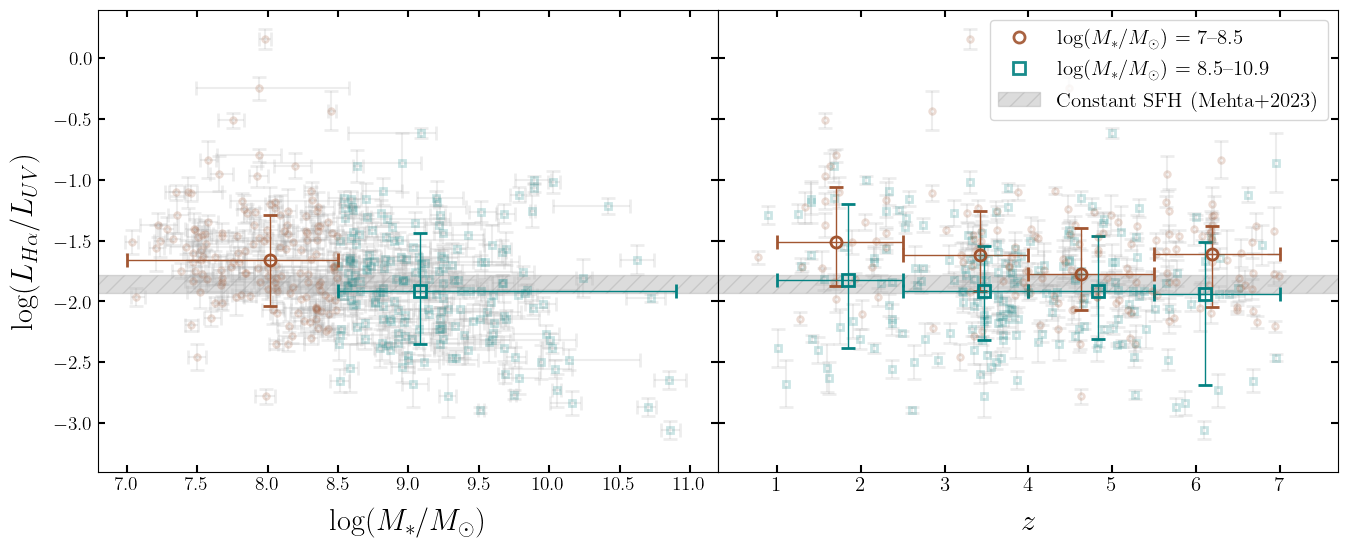

In [30]:
colors = ['teal','sienna']
markers = {'7-8.5': 'o', '8.5-10.9': 's'}

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
ax_mass = axes[0]
ax_z = axes[1]

# ------------------ LEFT PANEL: MASS VS LUMINOSITY RATIO ------------------
ax_mass.set_xlabel(r'log($M_*$/$M_{\odot}$)', fontsize=22, labelpad=10)
ax_mass.set_ylabel(r'log($L_{H\alpha}$/$L_{UV}$)', fontsize=22, labelpad=10)

for i, m_bin in enumerate(sample_df['MASS BIN'].unique()):
    mass_bin_df = sample_df[sample_df['MASS BIN'] == m_bin]

    # Stellar mass (x) and Hα/UV ratio (y)
    x_data = mass_bin_df['MASS MEDIAN']
    x_err_lower = mass_bin_df['MASS 16% ERROR']
    x_err_upper = mass_bin_df['MASS 84% ERROR']
    x_err = [x_err_lower, x_err_upper]
    
    y_data = mass_bin_df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO']
    y_err = mass_bin_df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO ERROR']
    
    ax_mass.errorbar(x_data, y_data, xerr=x_err, yerr=y_err, ecolor='#A9A9A9',
                  color=colors[i], alpha=0.2, fmt='o', marker=markers[m_bin],
                  markerfacecolor='none', markeredgewidth=2, markersize=4, capsize=5)

for i, row in mass_stats2.iterrows():
    m_bin = row['MASS BIN']
    color = colors[1] if m_bin == '7-8.5' else colors[0]
    ax_mass.errorbar(
        row['MEDIAN MASS'], row['MEDIAN RATIO'],
        yerr=[[row['BOTTOM ERR RATIO']], [row['TOP ERR RATIO']]],
        xerr=[[row['LEFT ERR MASS']], [row['RIGHT ERR MASS']]],
        ecolor=color, elinewidth=1, color=color, alpha=0.98,
        fmt='o', marker=markers[m_bin], markerfacecolor='none', 
        markeredgewidth=2, markersize=8, capsize=5
    )

# Shaded theoretical region from Mehta+2023
mehta_line = ax_mass.fill_between([6, 12], -1.93, -1.78, color='#A9A9A9', hatch='//', 
                               alpha=0.4, label='Constant SFH (Mehta+2023)')

# ===== Right Panel: Redshift vs Lum Ratio =====
ax_z.set_xlabel(r'$z$', fontsize=22, labelpad=10)

# Shaded theoretical region from Mehta+2023
mehta_line = ax_z.fill_between([0, 8], -1.93, -1.78, color='#A9A9A9', hatch='//', 
                               alpha=0.4, label='Constant SFH (Mehta+2023)')

for i, m_bin in enumerate(sample_df['MASS BIN'].unique()):
    mass_bin_df = sample_df[sample_df['MASS BIN'] == m_bin]
    redshift = mass_bin_df['Z SPEC']
    log_lum_ratio = mass_bin_df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO']
    log_lum_ratio_err = mass_bin_df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO ERROR']
    ax_z.errorbar(redshift, log_lum_ratio, yerr=log_lum_ratio_err, ecolor='#A9A9A9',
                  color=colors[i], alpha=0.2, fmt='o', marker=markers[m_bin],
                  markerfacecolor='none', markeredgewidth=2, markersize=4, capsize=5)

for i, row in mass_stats.iterrows():
    m_bin = row['MASS BIN']
    color = colors[1] if m_bin == '7-8.5' else colors[0]
    ax_z.errorbar(
        row['MEDIAN Z'], row['MEDIAN RATIO'],
        yerr=[[row['BOTTOM ERR RATIO']], [row['TOP ERR RATIO']]],
        xerr=[[row['LEFT ERR Z']], [row['RIGHT ERR Z']]],
        ecolor=color, elinewidth=1, color=color, alpha=0.98,
        fmt='o', marker=markers[m_bin], markerfacecolor='none', 
        markeredgewidth=2, markersize=8, capsize=5
    )

# ===== Legend & Styling =====
legend_handles = [
    Line2D([0], [0], marker='o', color='sienna', markersize=8, 
           markerfacecolor='none', markeredgewidth=2, alpha=0.9, 
           linestyle='None', label=r'log($M_*$/$M_{\odot}$) = 7–8.5'),
    Line2D([0], [0], marker='s', color='teal', markersize=8, 
           markerfacecolor='none', markeredgewidth=2, alpha=0.9, 
           linestyle='None', label=r'log($M_*$/$M_{\odot}$) = 8.5–10.9'),
    mehta_line
]
ax_z.legend(handles=legend_handles, fontsize=15, loc='upper right')

# Shared Y settings
for ax in axes:
    ax.set_ylim(-3.4, 0.4)
    ax.tick_params(axis="both", direction="in", labelsize=14, top=True, right=True, length=5, width=1.5)

# X-limits
ax_z.set_xlim(0.3, 7.7)
ax_mass.set_xlim(6.8, 11.2)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.tick_params(axis="both", direction="in", labelsize=15, top=True, right=True, length=5, width=1.5)
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('../outputs/plots/lum_ratio_redshift_mass.pdf',dpi=500,bbox_inches='tight')
plt.show()

## Analyzing magnitude vs stellar mass

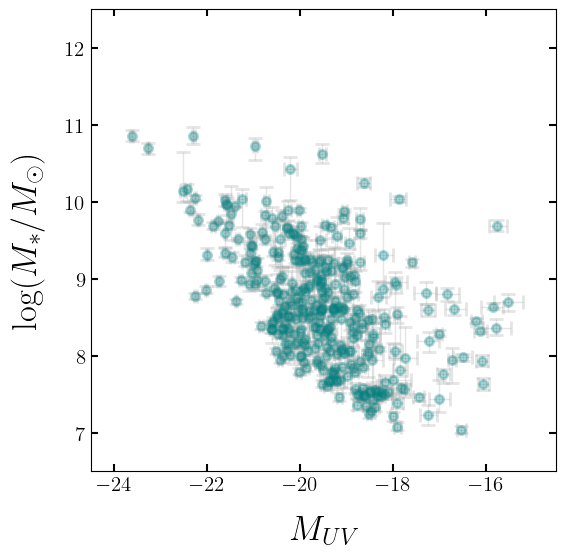

In [31]:
plt.figure(figsize=(6,6))
plt.xlabel(r'$M_{UV}$', fontsize=25, labelpad=15)
plt.ylabel(r'log($M_*$/$M_{\odot}$)', fontsize=25, labelpad=15)

mags = sample_df['ABSOLUTE MAG 1500 MEDIAN']
mass = sample_df['MASS MEDIAN']
xbot = mags - sample_df['ABSOLUTE MAG 1500 16% ERROR']
xtop = sample_df['ABSOLUTE MAG 1500 84% ERROR'] - mags

plt.errorbar(mags, mass, alpha=0.3, xerr=(xbot,xtop), yerr=(sample_df['MASS 16% ERROR'],sample_df['MASS 84% ERROR']), ecolor='#A9A9A9', 
             elinewidth=1, color=color, fmt='o', markeredgewidth=2, markersize=6, capsize=5)

plt.ylim(6.5,12.5)
plt.xlim(-24.5,-14.5)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.tick_params(axis="both", direction="in", labelsize=15, top=True, right=True, length=5, width=1.5)
plt.savefig('../outputs/plots/mag_vs_mass.png',dpi=500,bbox_inches='tight')
plt.show()

In [32]:
median_ratios = []
median_zs = []
top_err = []
bot_err = []
z_left_err = []
z_right_err = []
list_z_bins = []
list_mags = []
sample_size = []

# ----------------------------------------------
mag_labels = ['-24 - -20', '-20 - -14']
magnitudes = [-24,-20,-14]
# ----------------------------------------------

sample_df['M_UV BIN'] = pd.cut(sample_df['ABSOLUTE MAG 1500 MEDIAN'], bins=magnitudes, labels=mag_labels, right=False)

for i, z_bin in enumerate(z_bins):
    # current Z BIN
    df_z_bin = sample_df[sample_df['Z BIN'] == z_bin]
    
    for j, m_bin in enumerate(mag_labels):
        # current MASS BIN
        mag_bin_df = df_z_bin[df_z_bin['M_UV BIN'] == m_bin]

        median_ratio = np.median(mag_bin_df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO'])
        median_z = np.median(mag_bin_df['Z SPEC'])

        # get the bin edges from the label (e.g., '1-2.5' → zmin=1.0, zmax=2.5)
        zmin, zmax = map(float, z_bin.split('-'))
        z_left_err.append(median_z - zmin)
        z_right_err.append(zmax - median_z)

        p16, p84 = np.percentile(mag_bin_df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO'], [16, 84])
        bot_err.append(median_ratio - p16)
        top_err.append(p84 - median_ratio)

        median_ratios.append(median_ratio)
        median_zs.append(median_z)
        list_z_bins.append(z_bin)
        list_mags.append(m_bin)
        sample_size.append(len(mag_bin_df))

# saving stats from correlation computation
mass_stats = pd.DataFrame()
mass_stats['Z BIN'] = list_z_bins
mass_stats['MEDIAN RATIO'] = median_ratios
mass_stats['BOTTOM ERR RATIO'] = bot_err
mass_stats['TOP ERR RATIO'] = top_err
mass_stats['MEDIAN Z'] = median_zs
mass_stats['LEFT ERR Z'] = z_left_err 
mass_stats['RIGHT ERR Z'] = z_right_err
mass_stats['M_UV BIN'] = list_mags
mass_stats['sample size'] = sample_size
mass_stats

,Z BIN,MEDIAN RATIO,BOTTOM ERR RATIO,TOP ERR RATIO,MEDIAN Z,LEFT ERR Z,RIGHT ERR Z,M_UV BIN,sample size
0,1-2.5,-2.263451,0.243145,0.704155,2.16200,1.16200,0.33800,-24 - -20,9
1,1-2.5,-1.638044,0.515266,0.486153,1.68500,0.68500,0.81500,-20 - -14,49
2,2.5-4,-2.095766,0.352236,0.365938,3.46560,0.96560,0.53440,-24 - -20,36
3,2.5-4,-1.698225,0.408758,0.383637,3.43845,0.93845,0.56155,-20 - -14,76
4,4-5.5,-2.065875,0.281682,0.396394,4.89620,0.89620,0.60380,-24 - -20,43
5,4-5.5,-1.717878,0.291730,0.340604,4.62345,0.62345,0.87655,-20 - -14,60
6,5.5-7,-1.978070,0.618623,0.494503,6.22700,0.72700,0.77300,-24 - -20,28
7,5.5-7,-1.652756,0.243715,0.379990,6.17285,0.67285,0.82715,-20 - -14,42


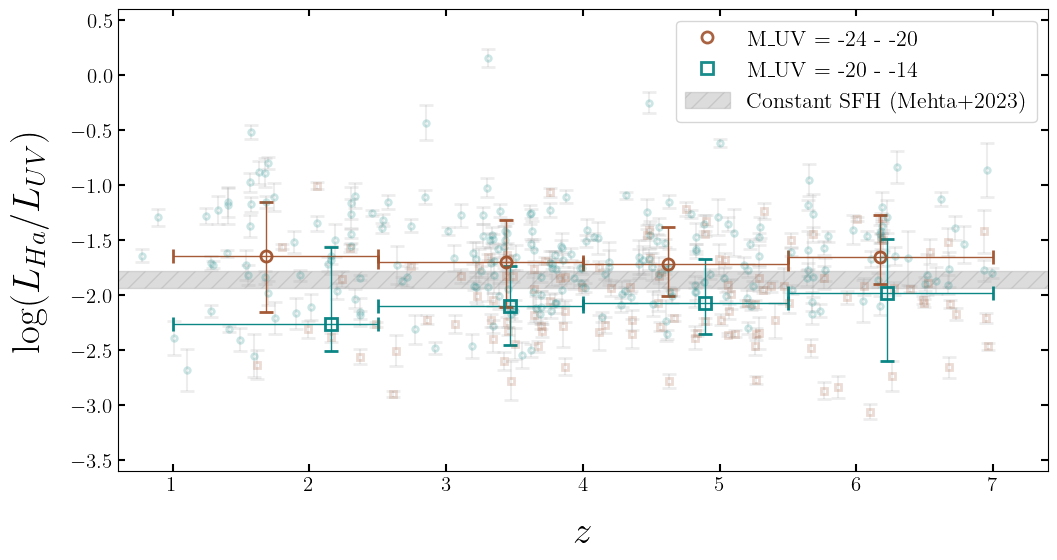

In [33]:
colors = ['sienna','teal']
markers = {'-24 - -20': 's', '-20 - -14': 'o'}
plt.figure(figsize=(12,6))
plt.xlabel(r'$z$', fontsize=28, labelpad=15)
plt.ylabel(r'log($L_{Ha}$/$L_{UV}$)', fontsize=28, labelpad=16)

# theoretical threshold
mehta_line = plt.fill_between(
    [0.5, 7.5],  # x-range of the shaded region
    -1.93, -1.78,  # y-limits for the shaded region
    color='#A9A9A9',  
    hatch='//',
    alpha=0.4,
    label='Constant SFH (Mehta+2023)'
)

for i, m_bin in enumerate(sample_df['M_UV BIN'].unique()):

    # data
    mag_bin_df = sample_df[sample_df['M_UV BIN'] == m_bin]
    log_lum_ratio = mag_bin_df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO']
    log_lum_ratio_err = mag_bin_df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO ERROR']
    redshift = mag_bin_df['Z SPEC']

    plt.errorbar(redshift,log_lum_ratio, yerr=log_lum_ratio_err, ecolor='#A9A9A9', color=colors[i], alpha=0.2, 
                 fmt='o', marker=markers[m_bin], markerfacecolor='none', markeredgewidth=2, markersize=4, capsize=5)

for i, row in mass_stats.iterrows():

    m_bin = mass_stats['M_UV BIN'].iloc[i]

    # if low mass
    if m_bin == '-24 - -20':
        color = colors[1]
    else:
        color = colors[0]
    
    redshift = mass_stats['MEDIAN Z'].iloc[i]
    log_lum_ratio = mass_stats['MEDIAN RATIO'].iloc[i]
    bot_err_ratio = mass_stats['BOTTOM ERR RATIO'].iloc[i]
    top_err_ratio = mass_stats['TOP ERR RATIO'].iloc[i]
    left_err_z = mass_stats['LEFT ERR Z'].iloc[i]
    right_err_z = mass_stats['RIGHT ERR Z'].iloc[i]
    
    plt.errorbar(redshift,log_lum_ratio, yerr=[[bot_err_ratio],[top_err_ratio]], xerr=[[left_err_z],[right_err_z]], ecolor=color, 
                 elinewidth=1, color=color, alpha=0.95, fmt='o', marker=markers[m_bin], markerfacecolor='none', markeredgewidth=2, markersize=8, capsize=5)

legend_handles = [
    Line2D([0], [0], marker='o', color='sienna', markersize=8, markerfacecolor='none', markeredgewidth=2, alpha=0.9, linestyle='None', label=r'M_{UV} = -24 - -20'),
    Line2D([0], [0], marker='s', color='teal', markersize=8, markerfacecolor='none', markeredgewidth=2, alpha=0.9, linestyle='None', label=r'M_{UV} = -20 - -14'),
    mehta_line
]
plt.legend(handles=legend_handles, fontsize=16, loc='upper right')

plt.ylim(-3.6,0.6)
plt.xlim(0.6,7.4)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.tick_params(axis="both", direction="in", labelsize=15, top=True, right=True, length=5, width=1.5)
plt.savefig('../outputs/plots/lum_ratio_redshift_mag.pdf',dpi=500,bbox_inches='tight')
plt.show()

# Ha-to-UV luminosity ratio vs. stellar mass

In [34]:
# a dictionary where the keys are the bin values and the values are the corresponding DataFrames
df_split_by_bins = {}

# Iterate over each unique value in 'Z BIN'
for bin_value in bins:
    # Filter the main DataFrame for each bin_value
    df_split_by_bins[bin_value] = sample_df[sample_df['Z BIN'] == bin_value]

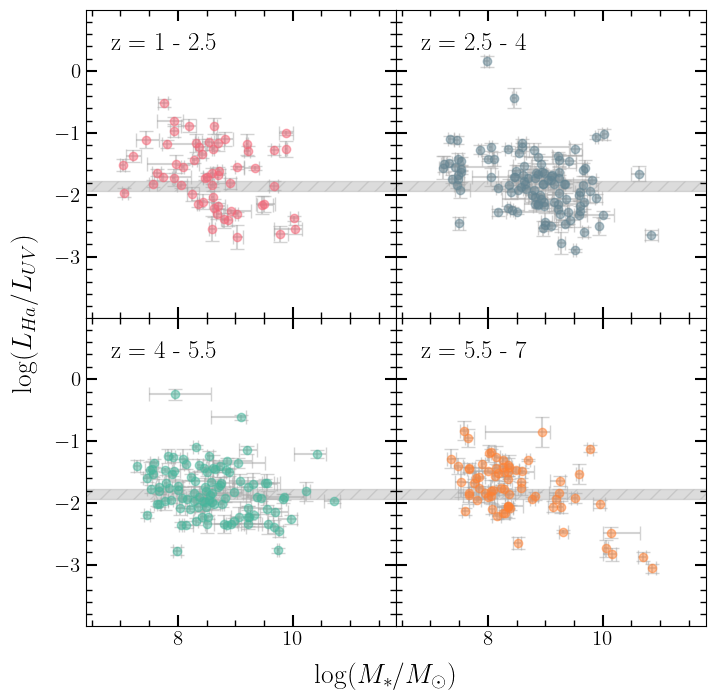

In [35]:
# Create 2x2 grid for 4 subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
fig.supxlabel(r'log($M_*$/$M_{\odot}$)', fontsize=20, y=0.03)
fig.supylabel(r'log($L_{Ha}$/$L_{UV}$)', fontsize=20, x=0.03)

for i, bin in enumerate(bins):
    ax = axs[i//2, i%2]
    
    # Data from current z-bin
    df = df_split_by_bins[bin]

    y_data = df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO']
    y_data_err = df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO ERROR']
    x_data = df['MASS MEDIAN']
    xtop = df['MASS 16% ERROR']
    xbot = df['MASS 84% ERROR']

    # data
    ax.errorbar(x_data, y_data, xerr=(xtop, xbot), yerr=y_data_err, color=color_list[i], ecolor='#A9A9A9', alpha=0.5, 
                fmt='o', markersize=6, capsize=5)
    

    # For each redshift bin, plot a theoretical threshold
    equilibrium_val = ax.fill_between(
        [6, 12],  # x-range of the shaded region
        -1.93, -1.78,  # y-limits for the shaded region
        color='#A9A9A9',  
        hatch='//',
        alpha=0.4,
        label='Constant SFH (Mehta+2023)'
    )

    # Legend text
    ax.text(
        0.08, 0.87,  
        label_list[i],  
        color='black', 
        fontsize=18, 
        fontweight='heavy',
        transform=ax.transAxes  
    )
    
    # ax.set_ylim(-4.6, 0.8)
    # ax.set_xlim(6.3, 11.8)

    # adding major & minor ticks on all sides
    ax.tick_params(axis="both", direction="in", labelsize=15, top=True, right=True, length=8, width=1.5)
    
    # adding minor ticks
    ax.minorticks_on()
    ax.tick_params(axis="both", which="minor", direction="in", length=4, width=1.0, top=True, right=True)

    ax.set_xlim(6.4,11.8)
    ax.set_ylim(-3.99,0.99)

plt.subplots_adjust(wspace=0, hspace=0)  
plt.savefig('../outputs/plots/lum_ratio_stellar_mass.pdf',dpi=500,bbox_inches='tight')
plt.show()